In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
# Check for missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
categorical = [c for c in df.columns if df[c].dtype == 'object']
numerical = [c for c in df.columns if df[c].dtype != 'object']

categorical


['lead_source', 'industry', 'employment_status', 'location']

In [6]:
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [7]:
# Replace missing values
for c in categorical:
    df[c] = df[c].fillna('NA')

for c in numerical:
    df[c] = df[c].fillna(0.0)

In [8]:
df.isnull().sum().sum()

np.int64(0)

In [22]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Split the data: 60% train, 20% validation, 20% test
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [21]:
print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

print(f"Total shape:", df_train.shape[0] + df_val.shape[0] + df_test.shape[0])

Train shape: (877, 9)
Validation shape: (292, 9)
Test shape: (293, 9)
Total shape: 1462


In [24]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1

In [25]:
from sklearn.metrics import roc_auc_score

In [ ]:
num_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

In [27]:
aucs = {}

for c in num_features:
    score = df_train[c]
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    
    aucs[c] = auc

print("ROC AUC scores by feature:")
for k, v in aucs.items():
    print(f"{k}: {v:.3f}")

# Identify the best feature
best_feature = max(aucs, key=aucs.get)
print(f"\nFeature with highest AUC: {best_feature} ({aucs[best_feature]:.3f})")    

ROC AUC scores by feature:
lead_score: 0.611
number_of_courses_viewed: 0.765
interaction_count: 0.727
annual_income: 0.545

Feature with highest AUC: number_of_courses_viewed (0.765)


### Question 2

In [28]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [29]:
# Combine categorical and numerical features
features = categorical + numerical
features.remove('converted') if 'converted' in features else None 

In [30]:
train_dict = df_train[features].to_dict(orient='records')
val_dict = df_val[features].to_dict(orient='records')
test_dict = df_test[features].to_dict(orient='records')

In [31]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [32]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [33]:
y_pred_val = model.predict_proba(X_val)[:, 1]

In [34]:
auc = roc_auc_score(y_val, y_pred_val)

print(f"AUC on validation dataset: {auc:.3f}")

AUC on validation dataset: 0.794


### Question 3

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [36]:
thresholds = np.linspace(0, 1, 101)

precision = []
recall = []

for t in thresholds:
    preds = (y_pred_val >= t).astype(int)
    precision.append(precision_score(y_val, preds))
    recall.append(recall_score(y_val, preds))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


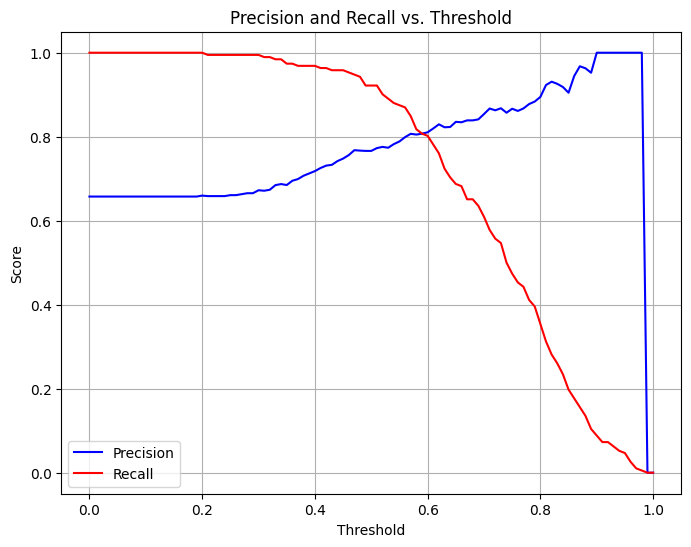

In [37]:
# Plot precision and recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# Find threshold where precision and recall intersect (closest point)
diff = np.abs(np.array(precision) - np.array(recall))
best_threshold = thresholds[diff.argmin()]

print(f"Threshold where precision and recall intersect: {best_threshold:.3f}")

Threshold where precision and recall intersect: 0.590


### Question 4

In [40]:
thresholds = np.linspace(0, 1, 101)

In [41]:
f1_scores = []

for t in thresholds:
    preds = (y_pred_val >= t).astype(int)
    p = precision_score(y_val, preds)
    r = recall_score(y_val, preds)
    f1 = 0 if (p + r) == 0 else (2 * p * r) / (p + r)
    f1_scores.append(f1)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


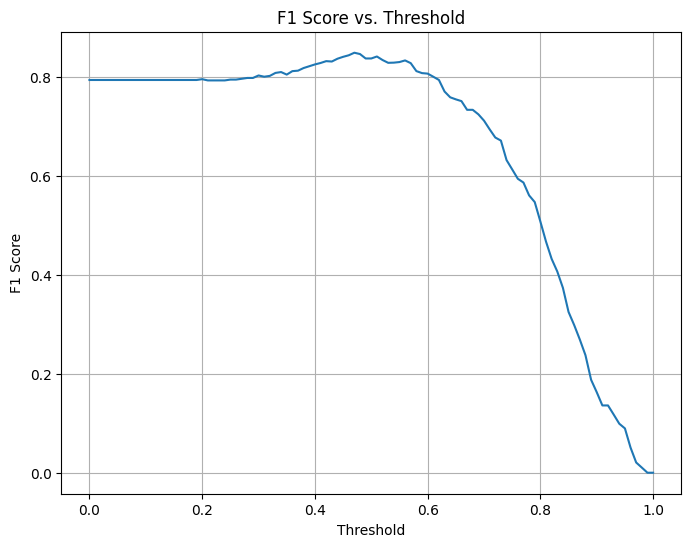

In [42]:
# Plot F1 vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()

In [44]:
best_f1 = max(f1_scores)
best_threshold_f1 = thresholds[np.argmax(f1_scores)]

print(f"Max F1 score: {best_f1:.3f}")
print(f"Threshold with max F1: {best_threshold_f1:.3f}")

Max F1 score: 0.848
Threshold with max F1: 0.470


In [46]:
options = np.array([0.14, 0.34, 0.54, 0.74])
closest_option = options[np.argmin(np.abs(options - best_threshold_f1))]
print(f"Closest option: {closest_option:.2f}")

Closest option: 0.54


### Question 5

In [47]:
from sklearn.model_selection import KFold

In [48]:
df_full_train = pd.concat([df_train, df_val], ignore_index=True)
y_full_train = np.concatenate([y_train, y_val])

In [49]:
features = categorical + numerical
features = [c for c in features if c != 'converted']

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
    df_tr = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_va = df_full_train.iloc[val_idx].reset_index(drop=True)
    y_tr = y_full_train[train_idx]
    y_va = y_full_train[val_idx]

    dv = DictVectorizer(sparse=False)
    train_dict = df_tr[features].to_dict(orient='records')
    val_dict = df_va[features].to_dict(orient='records')

    X_tr = dv.fit_transform(train_dict)
    X_va = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_tr, y_tr)

    y_pred = model.predict_proba(X_va)[:, 1]
    auc = roc_auc_score(y_va, y_pred)
    scores.append(auc)

    print(f"Fold {fold}: AUC = {auc:.3f}")

Fold 1: AUC = 0.807
Fold 2: AUC = 0.807
Fold 3: AUC = 0.865
Fold 4: AUC = 0.833
Fold 5: AUC = 0.815


In [53]:
mean_auc = np.mean(scores)
std_auc = np.std(scores)

print("\n5-Fold CV results")
print(f"Mean AUC: {mean_auc:.3f}")
print(f"Std of AUC: {std_auc:.6f}")


5-Fold CV results
Mean AUC: 0.825
Std of AUC: 0.021987


In [54]:
options = np.array([0.0001, 0.006, 0.06, 0.36])
closest_option = options[np.argmin(np.abs(options - std_auc))]
print(f"Closest option: {closest_option}")

Closest option: 0.006


### Question 6

In [55]:
# KFold CV to tune C exactly like in the notebook
Cs = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
results = []

for C in Cs:
    fold_scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        # Split
        df_tr = df_full_train.iloc[train_idx].reset_index(drop=True)
        df_va = df_full_train.iloc[val_idx].reset_index(drop=True)
        y_tr = y_full_train[train_idx]
        y_va = y_full_train[val_idx]

        # DictVectorizer fit on train fold
        dv = DictVectorizer(sparse=False)
        X_tr = dv.fit_transform(df_tr[features].to_dict(orient='records'))
        X_va = dv.transform(df_va[features].to_dict(orient='records'))

        # Model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_tr, y_tr)

        # AUC on validation fold
        y_pred = model.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, y_pred)
        fold_scores.append(auc)

    mean_auc = float(np.mean(fold_scores))
    std_auc  = float(np.std(fold_scores))
    print(f"C={C:<10} | mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}")
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

C=1e-06      | mean AUC = 0.543 | std = 0.025
C=0.001      | mean AUC = 0.864 | std = 0.014
C=1          | mean AUC = 0.825 | std = 0.022


In [57]:
best_C, best_mean, best_std = None, -1.0, float("inf")
for C, m, s in results:
    if (m > best_mean) or (m == best_mean and s < best_std) or (m == best_mean and s == best_std and C < best_C):
        best_C, best_mean, best_std = C, m, s

print(f"\nBest C: {best_C} (mean AUC={best_mean:.3f}, std={best_std:.3f})")


Best C: 0.001 (mean AUC=0.864, std=0.014)
